In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#import argparse
import numpy as np
import pandas as pd
import re

#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.cuda.amp import GradScaler

#import rdkit
#import math

import random
#from random import randrange
from random import shuffle

from typing import Optional, List, Tuple

#activation function
from packaging import version
from torch import Tensor

import logging
logger = logging.getLogger(__name__)


# In[2]:


from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

# Re-enable RDKit warnings if needed
#RDLogger.EnableLog('rdApp.*')
# In[3]:


torch.set_default_dtype(torch.float32)
torch.set_default_device('cuda:2')
device = 'cuda:2'


# In[4]:


data = pd.read_csv('/home/10714016/gpt/data_processed.csv', index_col = False)
data = data.dropna(axis=0).reset_index(drop=True)
#data.drop(['SPLIT'], axis=1, inplace=True)
data


# In[5]:


pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
regex = re.compile(pattern)

data['sm_len'] = data['SMILES'].apply(lambda x: len(regex.findall(x.strip())))
data['sca_len'] = data['scaffold_SMILES'].apply(lambda x: len(regex.findall(x.strip())))

max_len = data['sm_len'].max()
sca_max_len = data['sca_len'].max()
print('Max_len:', max_len)
print('Max_len_sca:', sca_max_len)


# In[6]:


#whole_string = ' '.join(data['SMILES'] + data['scaffold_SMILES'])
#whole_string = sorted(list(set(regex.findall(whole_string))))
#print(whole_string)


# In[7]:


#moses
#whole_string = ['#', '%10', '%11', '%12', '(', ')', '-', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<', '=', 'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', '[B-]', '[BH-]', '[BH2-]', '[BH3-]', '[B]', '[C+]', '[C-]', '[CH+]', '[CH-]', '[CH2+]', '[CH2]', '[CH]', '[F+]', '[H]', '[I+]', '[IH2]', '[IH]', '[N+]', '[N-]', '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[N]', '[O+]', '[O-]', '[OH+]', '[O]', '[P+]', '[PH+]', '[PH2+]', '[PH]', '[S+]', '[S-]', '[SH+]', '[SH]', '[Se+]', '[SeH+]', '[SeH]', '[Se]', '[Si-]', '[SiH-]', '[SiH2]', '[SiH]', '[Si]', '[b-]', '[bH-]', '[c+]', '[c-]', '[cH+]', '[cH-]', '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '[s+]', '[sH+]', '[se+]', '[se]', 'b', 'c', 'n', 'o', 'p', 's']

#guacamol
whole_string = ['#', '%10', '%11', '%12', '(', ')', '-', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', '[B-]', '[BH-]', '[BH2-]', '[BH3-]', '[B]', '[C+]', '[C-]', '[CH+]', '[CH-]', '[CH2+]', '[CH2]', '[CH]', '[F+]', '[H]', '[I+]', '[IH2]', '[IH]', '[N+]', '[N-]', '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[N]', '[O+]', '[O-]', '[OH+]', '[O]', '[P+]', '[PH+]', '[PH2+]', '[PH]', '[S+]', '[S-]', '[SH+]', '[SH-]', '[SH]', '[Se+]', '[SeH+]', '[SeH]', '[Se]', '[Si-]', '[SiH-]', '[SiH2]', '[SiH]', '[Si]', '[b-]', '[bH-]', '[c+]', '[c-]', '[cH+]', '[cH-]', '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '[s+]', '[sH+]', '[se+]', '[se]', 'b', 'c', 'n', 'o', 'p', 's']

char_list = sorted(list(set(whole_string)))

stoi_dict = {'[PAD]': 0, '[BOS]': 1, '[EOS]': 2, '[MASK]': 3}
itos_dict = {}
for i, char in enumerate(char_list):
    stoi_dict[char] = i + 4

itos_dict = {i: char for i, char in enumerate(stoi_dict)}
vocab_size = len(stoi_dict)
vocab_size


# In[8]:


#x_tensor = y_tensor (dec_input的樣子)
class TestDataSet(Dataset):
    #molgpt
    def __init__(self, data, content, prop=None, aug_prob = 0.5):
        chars = sorted(list(set(content)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d smiles, %d unique characters.' % (data_size, vocab_size))
    
        self.data = data
        self.vocab_size = vocab_size
        self.smiles = data['SMILES']
        #self.scaffold = data['scaffold_SMILES']
        #self.prop = prop
        if prop is not None:
            if isinstance(prop, list):
                #a list of properties
                self.prop = {p: data[p] for p in prop}
            else:
                #single property
                self.prop = {prop: data[prop]}
        else:
            self.prop = None
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        smiles = self.smiles.iloc[idx]  # self.prop.iloc[idx, :].values  --> if multiple properties
        #scaffold = self.scaffold.iloc[idx]
        if self.prop is not None:
            # Handle multiple properties if self.props is a dictionary
            prop_values = {key: values.iloc[idx] for key, values in self.prop.items()}
        else:
            prop_values = None
    
        '''sca = scaffold.strip()    
        sca = sca.strip()
        sca = tokenization.tokenize_enc_input(sca)'''
        enc_input = smiles.strip()    
        enc_input = tokenization.tokenize_enc_input(enc_input)
        enc_input = torch.tensor(enc_input)
        #mask = (torch.tensor(enc_input) == stoi_dict['[MASK]']).float()
        #mask = (enc_input.clone() == stoi_dict['[MASK]']).float()
        
        #mask = mask.to(torch.float32)
        v_prop_tensor = {key: torch.tensor(value) for key, value in prop_values.items()} if prop_values else None
        #v_prop_tensor = torch.tensor([prop], dtype = torch.float)

        

       
        return enc_input, v_prop_tensor


# In[9]:


def mask_input(input_ids):
    max_pred = 90
    n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.25)))) # 15 % of tokens in one sentence
    cand_maked_pos = [i for i, token in enumerate(input_ids)
                        if token != stoi_dict['[BOS]'] and token != stoi_dict['[EOS]']]
    shuffle(cand_maked_pos)
    masked_tokens, masked_pos = [], []
    for pos in cand_maked_pos[:n_pred]:
        masked_pos.append(pos)
        masked_tokens.append(input_ids[pos])
        input_ids[pos] = stoi_dict['[MASK]']  # Make mask
    return input_ids


# In[10]:


import random

def generate_inserted_sequence(input_ids, char_list):
    start_index, end_index = 0, -1 
    
    for _ in range(5):
        random_element = random.choice(char_list)
        random_index = random.randint(start_index, len(input_ids) + end_index)
        input_ids[random_index:random_index] = [stoi_dict[random_element]]
    
    return input_ids


# In[11]:


#moses.ultis
def get_mol(smiles_or_mol):
    '''
    Loads SMILES/molecule into RDKit's object
    '''
    if isinstance(smiles_or_mol, str):
        if len(smiles_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smiles_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smiles_or_mol


# In[23]:


def detokenize_for_input(sequence, itos_dict):
    # Convert tensor to a list of lists
    nested_tokens = [itos_dict[token] for token in sequence]

    # Join the tokens to form a string for each sequence in the batch
    generated_smiles = ''.join(nested_tokens)
    #print(generated_smiles)
    
    #filtered_smiles = [smiles.split('[PAD]')[0] for smiles in generated_smiles]
    #print(filtered_smiles)

    return generated_smiles


# In[30]:


class tokenization:
    def tokenize_enc_input(smiles): #for x_tensor & y_tensor
        #batch = []
        smiles_block = regex.findall(smiles)
        tokens = [stoi_dict[s] for s in smiles_block]
        #input_ids = mask_input(tokens)
        input_ids = tokens

        '''if random.random() < 0.5:
            input_ids = mask_input(tokens)
        else:
            #input_ids = generate_inserted_sequence(input_ids, char_list)
            while True:
                input_tokens = tokens.copy()
                input_ids = generate_inserted_sequence(input_tokens, char_list)
                m = detokenize_for_input(input_ids, itos_dict)
                if get_mol(m) is None:
                    break'''
        #Paddings
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)

        # Zero Padding for masked tokens
        '''if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)'''
            #input_ids_tensor = torch.tensor(dtype=torch.long)
        #batch = [input_ids_tensor, masked_tokens, masked_pos]
        #return batch
        return input_ids
    def tokenize_dec_input(smiles):
        #batch = []
        smiles_block = regex.findall(smiles)
        tokens = [stoi_dict[s] for s in smiles_block]
        input_ids = [stoi_dict['[BOS]']] + tokens 


        #Paddings
        n_pad = max_len + 1 - len(input_ids)
        input_ids.extend([0] * n_pad)

            #input_ids_tensor = torch.tensor(dtype=torch.long)
        #batch = [input_ids_tensor, masked_tokens, masked_pos]
        #return batch
        return input_ids
    def tokenize_v_output(smiles):
        #batch = []
        smiles_block = regex.findall(smiles)
        tokens = [stoi_dict[s] for s in smiles_block]
        input_ids = tokens + [stoi_dict['[EOS]']]

        #Paddings
        n_pad = max_len + 1 - len(input_ids)
        input_ids.extend([0] * n_pad)

        return input_ids



# In[12]:


##layers


# In[13]:


'''class EmbeddingLayer(nn.Module):
    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.embed_dim)
        #self.pos_emb = nn.Embedding(config.max_position_embed, config.n_embed) #max_position_embeddings = max_len after tokenize
        self.type_emb = nn.Embedding(2, config.embed_dim)   #n_embed -> hidden_size
        if config.num_props:
            self.prop_nn = nn.Linear(config.num_props, config.embed_dim)

    def forward(self, input_ids, prop = None, scaffold = None):
        batch_size, sequence_len = input_ids.size()
        
        #pos_id = input_ids.new_tensor(range(sequence_len))
        #pos_id = pos_id.expand(batch_size, sequence_len)
        inputs_embeddings = self.tok_emb(input_ids) #size = [batch_size, 45, 64]
        #pos_embeddings = self.pos_emb(torch.tensor(pos_id, dtype = torch.long)) #size = [batch_size, 45, 64]
        type_embeddings = self.type_emb(torch.ones((batch_size, sequence_len), dtype=torch.long).cuda()) #size = [batch_size, 45, 64]
        x = inputs_embeddings + type_embeddings #size = [batch_size, 45, 64]

        #molgpt
        if self.config.num_props:
            type_embd = self.type_emb(torch.zeros((batch_size, 1), dtype = torch.long)) #size = [batch_size, 1, 64]
            if prop.ndim == 2:
                p = self.prop_nn(prop.double().unsqueeze(1))    # for single property
            #else:
                #p = self.prop_nn(prop)    # for multiproperty
            p += type_embd
            x = torch.cat([p, x], 1) #size = [batch_size, 45+1, 64]

        return x'''



# In[14]:


#MultiHeadAttention_for_Model
class RelativePosition(nn.Module):

    def __init__(self, embed_dim, max_relative_position):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_relative_position = max_relative_position
        #self.embeddings_table = nn.Parameter(torch.Tensor(max_relative_position * 2 + 1, embed_dim))
        self.embeddings_table = nn.Parameter(torch.Tensor(max_relative_position * 2 + 1, embed_dim).to(device))
        nn.init.xavier_uniform_(self.embeddings_table)

    def forward(self, length_q, length_k):
        range_vec_q = torch.arange(length_q, device=device)
        range_vec_k = torch.arange(length_k, device=device)
        distance_mat = range_vec_k[None, :] - range_vec_q[:, None]
        distance_mat_clipped = torch.clamp(distance_mat, -self.max_relative_position, self.max_relative_position)
        final_mat = distance_mat_clipped + self.max_relative_position
        final_mat = final_mat.long()
        embeddings = self.embeddings_table[final_mat].to(device)

        return embeddings

#from bart.modelling
class Attention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, embed_dim, num_heads, dropout = 0.0, is_decoder: bool = False):
        super().__init__()
        
        assert embed_dim % num_heads == 0
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.max_relative_position = 20
        self.is_decoder = is_decoder

        self.relative_position_k = RelativePosition(self.head_dim, self.max_relative_position)
        self.relative_position_v = RelativePosition(self.head_dim, self.max_relative_position)

        self.w_qs = nn.Linear(embed_dim, embed_dim)
        self.w_ks = nn.Linear(embed_dim, embed_dim)
        self.w_vs = nn.Linear(embed_dim, embed_dim)
        
        self.fc_output = nn.Linear(embed_dim, embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        #self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))
        self.scale = torch.sqrt(torch.tensor([self.head_dim]))
        
    def _shape(self, tensor: torch.tensor, seq_len: int, batch_size: int):
        return tensor.view(batch_size, seq_len, self.num_heads, self.head_dim).contiguous()
    

    def forward(
        self,
        hidden_states: torch.tensor,
        key_value_states: Optional[torch.tensor] = None,
        past_key_value: Optional[Tuple[torch.tensor]] = None,
        attention_mask: Optional[torch.tensor] = None,
        layer_head_mask: Optional[torch.tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.tensor, Optional[torch.tensor], Optional[Tuple[torch.tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        batch_size, seq_len, _ = hidden_states.size()

        # get query proj
        query = self._shape(self.w_qs(hidden_states), -1, batch_size)
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if ( #cross attention, cache, 預測第二個詞開始
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions    #key_states -> key, value_states -> value
            key = past_key_value[0]
            value = past_key_value[1]
        elif is_cross_attention: #訓練時cross attention; 預測時第一個字
            # cross_attentions
            key = self._shape(self.w_ks(key_value_states), -1, batch_size)
            value = self._shape(self.w_vs(key_value_states), -1, batch_size)
        elif past_key_value is not None: #預測
            # reuse k, v, self_attention
            key = self._shape(self.w_ks(hidden_states), -1, batch_size)
            value = self._shape(self.w_vs(hidden_states), -1, batch_size)
            key = torch.cat([past_key_value[0], key], dim=1) #cat: seq_len(?)
            value = torch.cat([past_key_value[1], value], dim=1) #cat: seq_len(?)
        else:
            # self_attention
            key = self._shape(self.w_ks(hidden_states), -1, batch_size)
            value = self._shape(self.w_vs(hidden_states), -1, batch_size)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key, value)
        
        #query = self.w_qs(x).view(batch_size, seq_len, self.n_heads, self.head_dim) #q_size = [bsz, seq_len, embed_dim]
        #key = self.w_ks(x).view(batch_size, seq_len, self.n_heads, self.head_dim) #k_size = [bsz, seq_len, embed_dim]
        #value = self.w_vs(x).view(batch_size, seq_len, self.n_heads, self.head_dim) #size = [bsz, seq_len, embed_dim]
        
        r_q1 = query.permute(0, 2, 1, 3) #bsz = [bsz, n_heads, seq_len, head_dim]
        r_k1 = key.permute(0, 2, 3, 1) #bsz = [bsz, n_heads, head_dim, seq_len]
        attn1 = torch.matmul(r_q1, r_k1) #size = [bsz, n_heads, seq_len, seq_len]

        r_q2 = query.transpose(0, 1).reshape(seq_len, batch_size*self.num_heads, self.head_dim)
        r_k2 = self.relative_position_k(seq_len, seq_len) #size = [seq_len, seq_len, head_dim]
        attn2 = torch.matmul(r_q2, r_k2.transpose(1, 2)) #size = [seq_len, batch_size*n_heads, seq_len]
        attn2 = attn2.view(seq_len, batch_size, self.num_heads, seq_len).permute(1, 2, 0, 3)
        attn = (attn1 + attn2) / self.scale #size = [bsz, n_heads, seq_len, seq_len]
        
        
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(1).repeat(1, self.num_heads, 1, 1)
            attn = attn.masked_fill(attention_mask == 1, -1e9)
        
        attn = self.dropout(torch.softmax(attn, dim = -1))
        
        r_v1 = value.permute(0, 2, 1, 3)
        weight1 = torch.matmul(attn, r_v1)
        r_v2 = self.relative_position_v(seq_len, seq_len)
        weight2 = attn.permute(2, 0, 1, 3).view(seq_len, batch_size*self.num_heads, seq_len)
        weight2 = torch.matmul(weight2, r_v2)
        weight2 = weight2.transpose(0, 1).view(batch_size, self.num_heads, seq_len, self.head_dim)
        
        x = weight1 + weight2 #size = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous() #size = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.embed_dim) #size = [batch size, query len, hid dim]
        
        x = self.fc_output(x) #size = [batch size, query len, hid dim]
        
        #len_q = query_states.size()
        
        
        return x, attn, past_key_value



# In[15]:


class FeedForward(nn.Module):
    def __init__(self, embed_dim: int, ffn_dim: int, acti_dropout: int, ffn_dropout: int):
        super().__init__()
        #self.embed_dim = config.embed_dim
        #self.ff_dim = congif.ff_dim
        #self.acti_dropout = config.acti_pdrop
        #self.ff_dropout = config.ff_pdrop
        #self.training = config.training
        
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_dim),
            PytorchGELUTanh(),
            nn.Dropout(acti_dropout),
            nn.Linear(ffn_dim, embed_dim),
            nn.Dropout(ffn_dropout)
        )
        
    def forward(self, x: Tensor) -> Tensor:
        return self.ffn(x)


# In[51]:


def get_attn_pad_mask(seq_q, seq_k, have_prop = False, is_encoder = True):                       # seq_q: [batch_size, seq_len] ,seq_k: [batch_size, seq_len]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)          # 判断 输入那些含有P(=0),用1标记 ,[batch_size, 1, len_k]
    if have_prop:
        if is_encoder:
            pad_attn_mask = torch.cat([pad_attn_mask, torch.zeros(batch_size, 1, 1, dtype=torch.bool)], dim=2) #property不遮
            return pad_attn_mask.expand(batch_size, len_q+1, len_k+1)
        else:
            return pad_attn_mask.expand(batch_size, len_q, len_k)
    else:
        return pad_attn_mask.expand(batch_size, len_q, len_k)  # 扩展成多维度


# In[17]:


def get_attn_subsequence_mask(seq):                               # seq: [batch_size, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)          # 生成上三角矩阵,[batch_size, tgt_len, tgt_len]
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  #  [batch_size, tgt_len, tgt_len]
    return subsequence_mask   


# In[18]:


def subs_with_inf_min(prop_tensor, config_prop):
    props = ['HBA', 'HBD', 'MW', 'NumRotBonds', 'QED', 'SAS', 'TPSA', 'logP']
    bsz = len(prop_tensor[config_prop[0]])
    na_props = [na_prop for na_prop in props if na_prop not in config_prop]
    prop_tensor.update({key: torch.tensor([-1e9] * bsz) for key in na_props})
    sorted_prop_tensor = [prop_tensor[key] for key in sorted(prop_tensor)]
    return sorted_prop_tensor


# In[19]:


class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.self_attn = Attention(embed_dim=self.embed_dim,
                                  num_heads=config.num_heads,
                                  dropout=config.attn_pdrop)
        self.attn_norm = nn.LayerNorm(self.embed_dim)
        #self.dropout = config.dropout
        #self.acti_fn = PytorchGELUTanh()
        #self.acti_dropout=config.acti_pdrop
        #self.fc1 = nn.Linear(self.embed_dim, config.encoder_ffn_dim)
        #self.fc2 = nn.Linear(config.encoder_ffn_dim, self.embed_dim)
        self.ffn = FeedForward(embed_dim=self.embed_dim, 
                               ffn_dim = config.ffn_dim, 
                               acti_dropout=config.acti_pdrop, 
                               ffn_dropout=config.ffn_pdrop)
        self.final_norm = nn.LayerNorm(self.embed_dim)
    
    def forward(self, hidden_states, 
                attention_mask = None, 
                layer_head_mask = None, 
                output_attn: Optional[bool] = True
               ) -> Tuple[torch.tensor, Optional[torch.tensor]]:
        
        residual = hidden_states
        hidden_states, attn_weights, _ = self.self_attn(hidden_states=hidden_states,
                                  attention_mask = attention_mask,
                                  layer_head_mask = layer_head_mask,
                                  output_attentions=output_attn)
        hidden_states = self.attn_norm(residual + hidden_states)
        residual = hidden_states
        #hidden_states = self.acti_fn(self.fc1(hidden_states))
        #hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        #hidden_states = self.fc2(hidden_states)
        #hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = self.ffn(hidden_states)
        hidden_states = self.final_norm(residual + hidden_states)
        
        if hidden_states.dtype == torch.float16 and (
            torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any()
        ):
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,) #size = [bsz, swq_len, dim]

        if output_attn:
            outputs += (attn_weights,)

        return outputs


# In[20]:


class DecoderLayer(nn.Module):
    def __init__(self, config): 
        super().__init__()
        self.embed_dim = config.embed_dim
        self.self_attn = Attention(embed_dim=self.embed_dim,
                                  num_heads=config.num_heads, #config.decoder_num_heads
                                  dropout=config.attn_pdrop,
                                  is_decoder=True,)
        self.self_attn_norm=nn.LayerNorm(self.embed_dim)
        self.encoder_attn = Attention(embed_dim=self.embed_dim,
                                      num_heads=config.num_heads, #config.decoder_num_heads
                                      dropout=config.attn_pdrop,
                                      is_decoder=True,)
        self.encoder_attn_norm = nn.LayerNorm(self.embed_dim)
        #self.dropout=config.dropout
        #self.acti_fn= PytorchGELUTanh()
        #self.acti_dropout=config.acti_pdrop
        #self.fc1 = nn.Linear(self.embed_dim, config.decoder_ffn_dim)
        #self.fc2 = nn.Linear(config.decoder_ffn_dim, self.embed_dim)
        self.ffn = FeedForward(embed_dim=self.embed_dim, 
                               ffn_dim = config.ffn_dim, 
                               acti_dropout=config.acti_pdrop, 
                               ffn_dropout=config.ffn_pdrop)
        self.final_norm=nn.LayerNorm(self.embed_dim)
    
    def forward(self,
        hidden_states: torch.tensor,
        attention_mask: Optional[torch.tensor] = None,
        encoder_hidden_states: Optional[torch.tensor] = None,
        encoder_attention_mask: Optional[torch.tensor] = None,
        layer_head_mask: Optional[torch.tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.tensor] = None,
        past_key_value: Optional[Tuple[torch.tensor]] = None,
        output_attentions: Optional[bool] = True,
        use_cache: Optional[bool] = False,
               ) -> Tuple[torch.tensor, Optional[Tuple[torch.tensor, torch.tensor]]]:
        residual = hidden_states

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        ##hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = self.self_attn_norm(residual + hidden_states)
        
        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            ##hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = self.encoder_attn_norm(residual + hidden_states)

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value
            
        # Fully Connected
        residual = hidden_states
        #hidden_states = self.activation_fn(self.fc1(hidden_states))
        #hidden_states = nn.functional.dropout(hidden_states, p=self.acti_dropout, training=self.training)
        #hidden_states = self.fc2(hidden_states)
        #hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = self.ffn(hidden_states)
        hidden_states = self.final_norm(residual + hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs


# In[21]:


##blocks


# In[62]:


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        #self.input_embedding = EmbeddingLayer(config)
                # input embedding stem
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.embed_dim)
        #self.pos_emb = nn.Embedding(config.max_position_embed, config.n_embed) #max_position_embeddings = max_len after tokenize
        self.type_emb = nn.Embedding(2, config.embed_dim)   #n_embed -> hidden_size
        '''if config.num_props:
            self.prop_nn = nn.Linear(5, config.embed_dim)'''
            
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(5)]) #2=n_layers

    def forward(self, sca, is_train = True):                                               # enc_inputs: [batch_size, src_len]
        #hidden_states = self.input_embedding(enc_inputs, prop)
        batch_size, sequence_len = sca.size()
        sca_embeddings = self.tok_emb(sca) #size = [batch_size, 45, 64]
        #pos_embeddings = self.pos_emb(torch.tensor(pos_id, dtype = torch.long)) #size = [batch_size, 45, 64]
        #type_embeddings = self.type_emb(torch.ones((batch_size, sequence_len), dtype=torch.long).cuda()) #size = [batch_size, 45, 64]
        hidden_states = sca_embeddings #+ type_embeddings #size = [batch_size, sca_len, 32]

        #molgpt
        '''if self.config.num_props:
            type_embd = self.type_emb(torch.zeros((batch_size, 1), dtype = torch.long)) #size = [batch_size, 1, 64]
            
            if is_train:
                #prop_tensors = [value.unsqueeze(1).float() for value in prop.values()]
                #prop_tensors = torch.cat(prop_tensors, dim=1) #size=[bsz, 1]
                #print('ori:', prop_tensors)
                prop_tensors = subs_with_inf_min(prop, config.prop)
                prop_tensors = torch.stack(prop_tensors, dim = 1)
                prop_tensors = prop_tensors.float() #size = [bsz, 5]

            else:
                prop_tensors = prop
            p = self.prop_nn(prop_tensors.unsqueeze(1)) #size=[bsz, 1, 32]

            hidden_states = torch.cat([p, hidden_states], 1)'''
        enc_self_attn_mask = get_attn_pad_mask(sca, sca)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_attn_weight = layer(hidden_states, attention_mask=enc_self_attn_mask)  # enc_outputs :   [batch_size, src_len, d_model], 
                                                                                 # enc_self_attn : [batch_size, n_heads, src_len, src_len]
            enc_self_attns.append(enc_attn_weight)
        return enc_outputs, enc_self_attns


# In[23]:


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tok_emb = nn.Embedding(config.vocab_size, config.embed_dim)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(3)]) #2=n_layers

    def forward(self, dec_inputs, enc_inputs, enc_outputs):                               # dec_inputs: [batch_size, tgt_len]
        batch_size, sequence_len = dec_inputs.size()
        hidden_states = self.tok_emb(dec_inputs) #size = [batch_size, 45, 64]                                                                                  # enc_intpus: [batch_size, src_len]
        #hidden_states = self.tgt_emb(dec_inputs, prop)                                            # [batch_size, tgt_len, d_model]       
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, is_encoder = False)       # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).to(device)    # [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + 
                                       dec_self_attn_subsequence_mask), 0)      # [batch_size, tgt_len, tgt_len]
        
        
        
        #cross_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)                     # [batc_size, tgt_len, src_len]
        dec_self_attns, cross_attns = [], []
        for layer in self.layers:                             # dec_outputs: [batch_size, tgt_len, d_model]
                                                              # dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
                                                              # dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, self_attn_weights, cross_attn_weights = layer(hidden_states, 
                                                                       attention_mask=dec_self_attn_mask, 
                                                                       encoder_hidden_states=enc_outputs)
            dec_self_attns.append(self_attn_weights)
            cross_attns.append(cross_attn_weights)
        return dec_outputs, dec_self_attns, cross_attns


# In[24]:


#transformer/activations.py
class PytorchGELUTanh(nn.Module):
    """
    A fast C implementation of the tanh approximation of the GeLU activation function. See
    https://arxiv.org/abs/1606.08415.

    This implementation is equivalent to NewGELU and FastGELU but much faster. However, it is not an exact numerical
    match due to rounding errors.
    """

    def __init__(self):
        super().__init__()
        if version.parse(torch.__version__) < version.parse("1.12.0"):
            raise ImportError(
                f"You are using torch=={torch.__version__}, but torch>=1.12.0 is required to use "
                "PytorchGELUTanh. Please upgrade torch."
            )

    def forward(self, input: Tensor) -> Tensor:
        return nn.functional.gelu(input, approximate="tanh")


# In[25]:


def smiles_loss(model_output, true_labels, padding):
    model_output = model_output.transpose(1, 2)
    loss = F.cross_entropy(model_output, true_labels, reduction='none')
    s_loss = torch.sum(loss * padding) / torch.sum(padding)
    

    return s_loss

Max_len: 100
Max_len_sca: 100


In [2]:
#MolGPT
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    attn_pdrop = 0.1
    resid_pdrop = 0.1
    acti_pdrop = 0.1 ##

    def __init__(self, vocab_size, **kwargs):
        self.vocab_size = vocab_size
        #self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    embed_dim = 768


# In[40]:

#for cloze
#config = GPTConfig(vocab_size=98, max_len = max_len + 1, embed_dim=128, num_heads = 8, 
                #dropout=0.0, acti_pdrop=0.0, ffn_pdrop=0.0, ffn_dim=256, num_props = 0,
                   #scaffold=False)#, prop = ['QED']) #test: vocab_size = 8, block_size = 10, max_len = 5
#for prop
config = GPTConfig(vocab_size=98, max_len = max_len, embed_dim=256, num_heads = 8, 
                dropout=0.0, acti_pdrop=0.0, ffn_pdrop=0.0, ffn_dim=512, num_props = 8,
                   scaffold=False)

#prop = ['MW', 'QED', 'SAS', 'TPSA', 'logP', 'HBA', 'HBD', 'NumRotBonds']



# In[59]:


class smiles_BERT(nn.Module):
    def __init__(self, config):
        super(smiles_BERT, self).__init__()
        self.encoder = Encoder()
        #self.proj = nn.Linear(config.embed_dim, config.vocab_size)
        self.prop_proj = nn.Linear(config.max_len, config.num_props)
        
    def forward(self, inputs, v_prop):
        enc_outputs, enc_self_attns = self.encoder(inputs)
        #logits = self.proj(enc_outputs) #size = [bsz, tgt_len, vocab_size]
        logits = enc_outputs.mean(dim=2) #size = [bsz, tgt_len]
        logits = self.prop_proj(logits) #size = [bsz, num_props]
        v_prop_tensors = [value.unsqueeze(1).float() for value in v_prop.values()] #size = [bsz, num_props]
        v_prop_tensors = torch.cat(v_prop_tensors, dim=1) #size=[bsz, 1]
        #v_prop_tensors = subs_with_inf_min(prop, config.prop)
        #v_prop_tensors = torch.stack(v_prop_tensors, dim = 1)
        #v_prop_tensors = prop_tensors.float() #size = [bsz, 5]
        #print('final:', v_prop_tensors)
        loss = nn.MSELoss()(logits, v_prop_tensors)
        rmse_loss = torch.sqrt(loss)
        #reshaped: output:[bsz * tgt_len, vocab_size], v_output:[bsz * tgt_len]
        return logits, rmse_loss

In [3]:
from sklearn.model_selection import train_test_split

# Define the proportion for the training set (0.7 for 70%)
training_proportion = 0.7
t_data = data
# Split the data into training and testing sets
train_data, val_data = train_test_split(t_data, test_size=1 - training_proportion, random_state=42)

train_data = TestDataSet(train_data, whole_string, 
                         prop = ['HBA', 'HBD', 'MW', 'NumRotBonds', 'QED', 'SAS', 'TPSA', 'logP'])
train_dataloader = DataLoader(train_data, batch_size=32)
val_data = val_data.sample(n=10000, random_state=42)
val_data = TestDataSet(val_data, whole_string, 
                       prop = ['HBA', 'HBD', 'MW', 'NumRotBonds', 'QED', 'SAS', 'TPSA', 'logP'])
val_dataloader = DataLoader(val_data, batch_size=4)

data has 2408021 smiles, 94 unique characters.
data has 10000 smiles, 94 unique characters.


In [4]:
ck_path = '/home/10714016/gpt/result/combined_data/encode5_prop_pp/checkpoint_cloze_1_0660_smiles_prop.pt'
checkpoint = torch.load(ck_path)

model = smiles_BERT(config)
model.load_state_dict(checkpoint)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device) # 移动模型到cuda

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
test_losses = []
total_test_loss = 0.0

batch = 0
true_values = []
predicted_values = []
print('start testing')
total_test_loss = 0.0
with torch.no_grad():  
    for test_smiles, test_v_prop in val_dataloader:
        test_logits, test_loss = model(test_smiles, test_v_prop)
        total_test_loss += test_loss
        test_v_prop_tensor = [value.unsqueeze(1).float() for value in test_v_prop.values()] #size = [bsz, num_props]
        test_v_prop_tensor = torch.cat(test_v_prop_tensor, dim=1) #size=[bsz, 1]
        true_values += test_v_prop_tensor
        predicted_values += test_logits

        batch += 1
    average_test_loss = total_test_loss / batch
    test_losses.append(average_test_loss.item())
                
print('test loss', average_test_loss)

In [ ]:
predicted_values

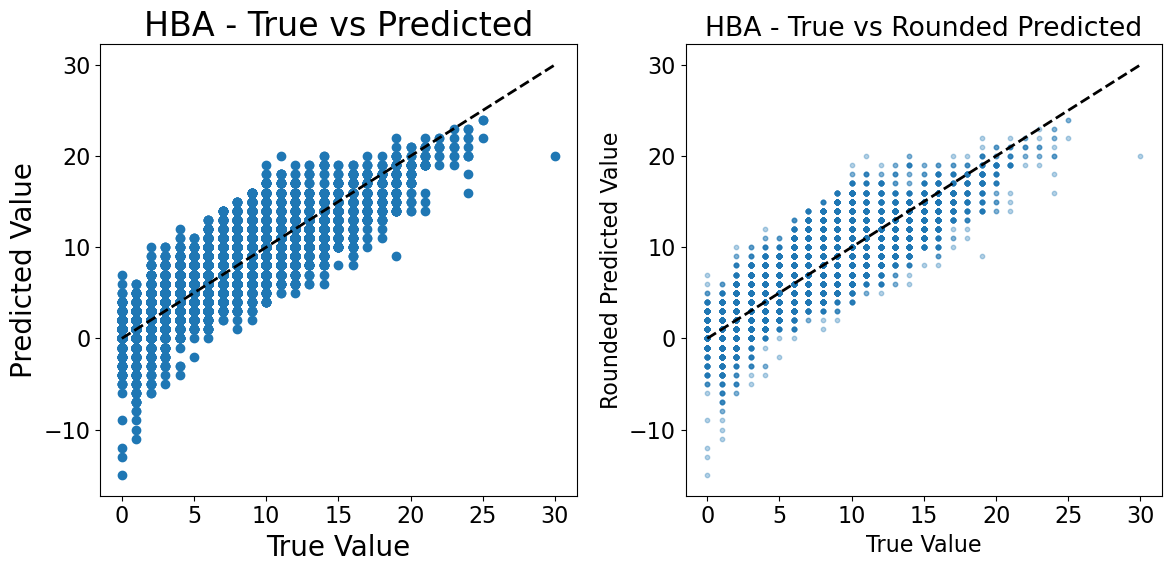

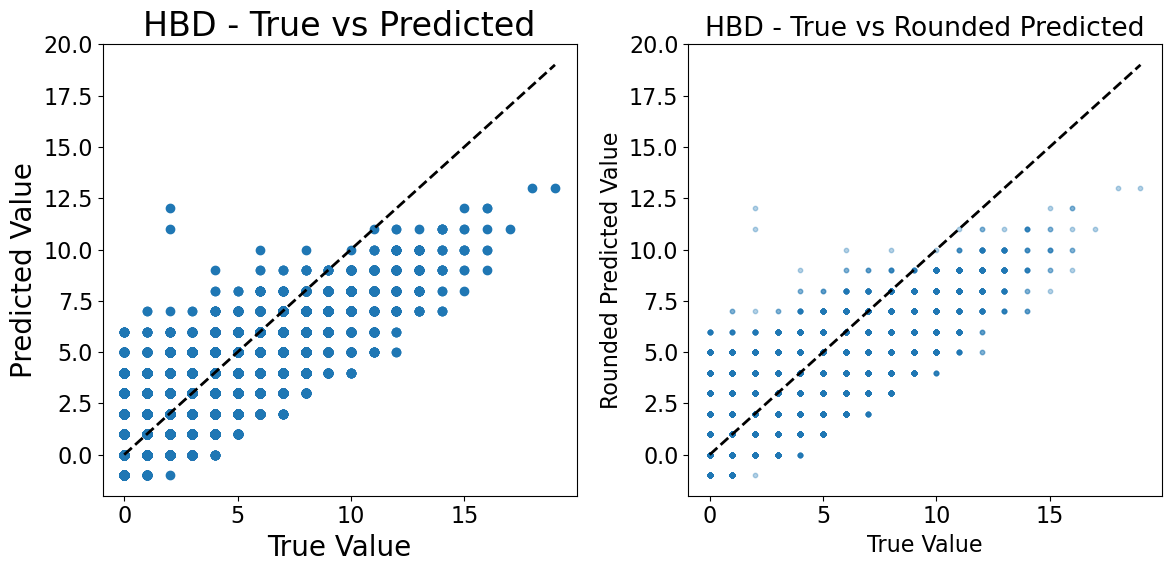

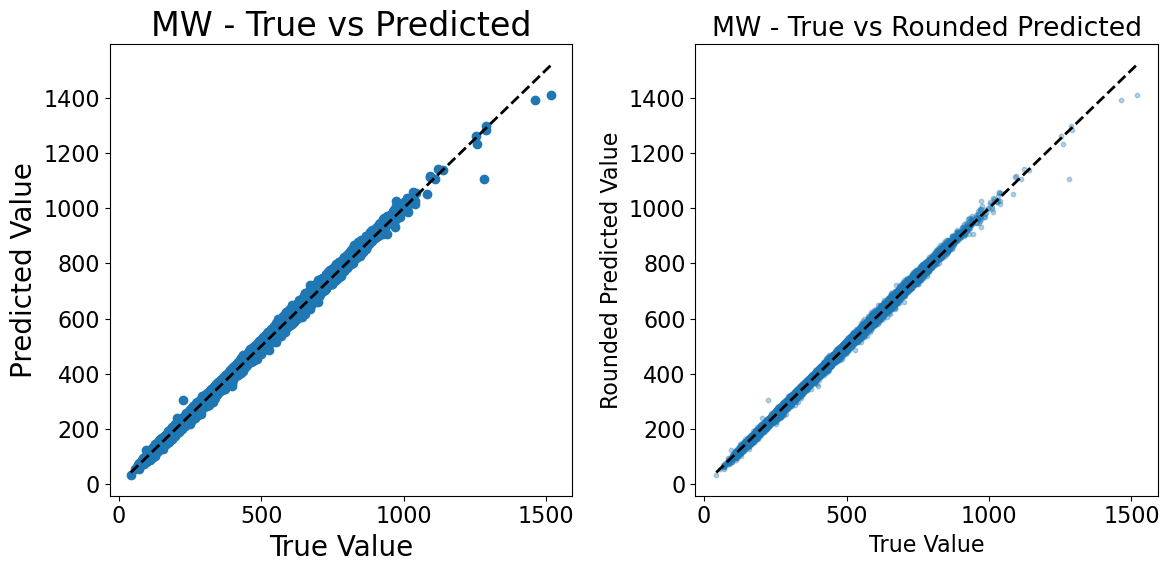

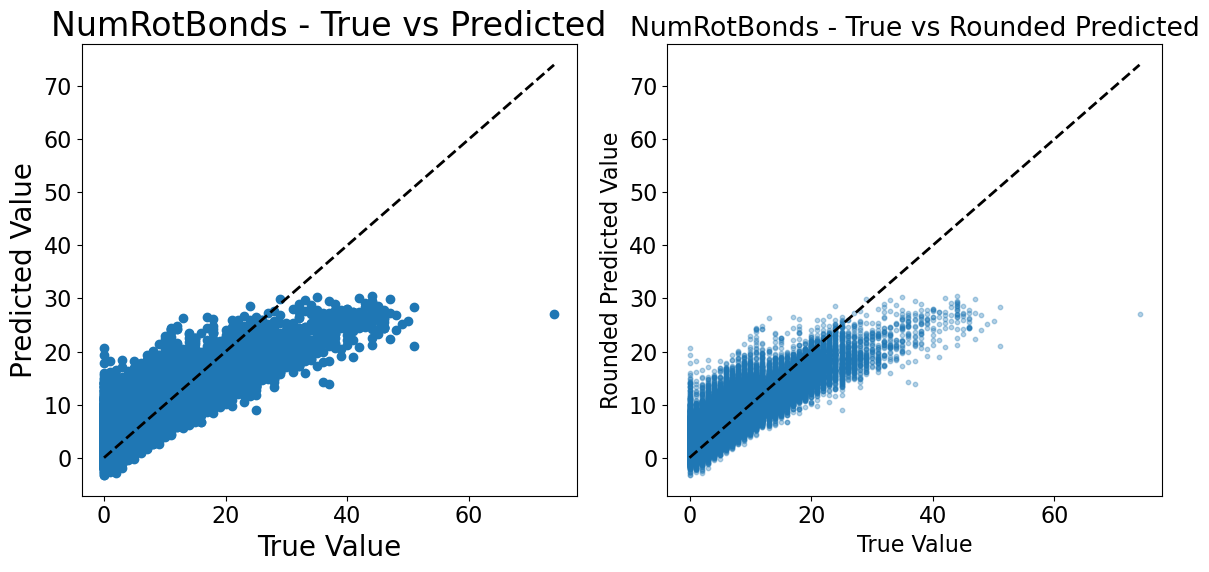

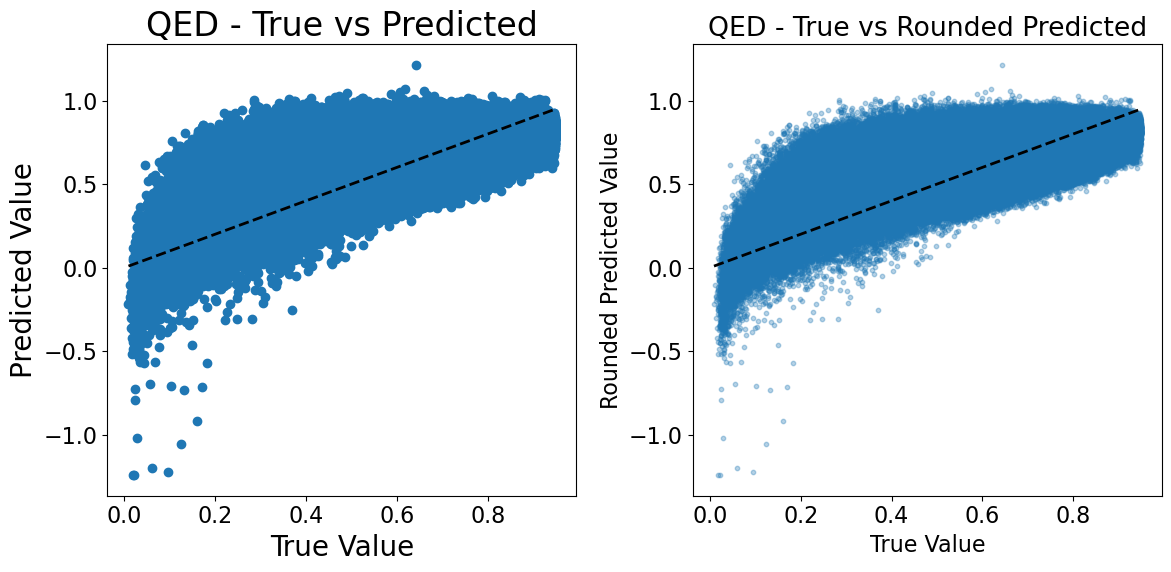

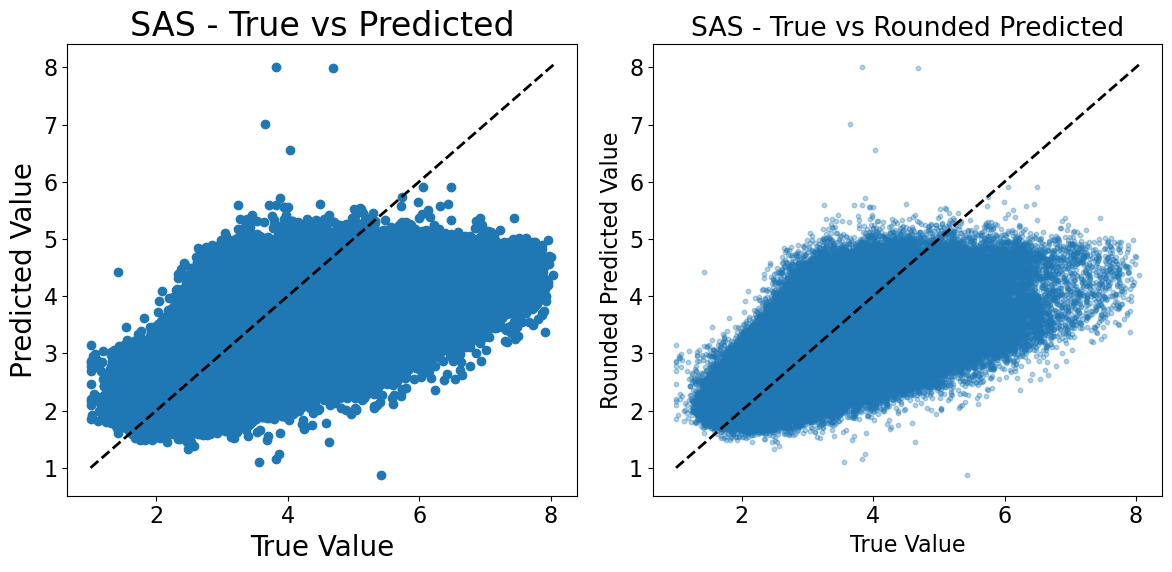

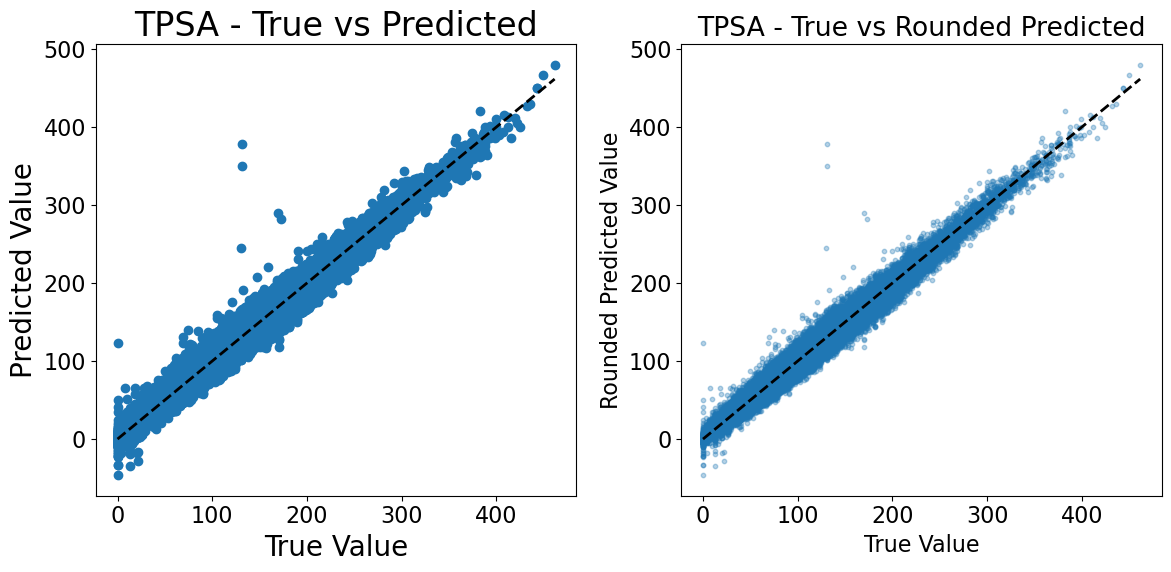

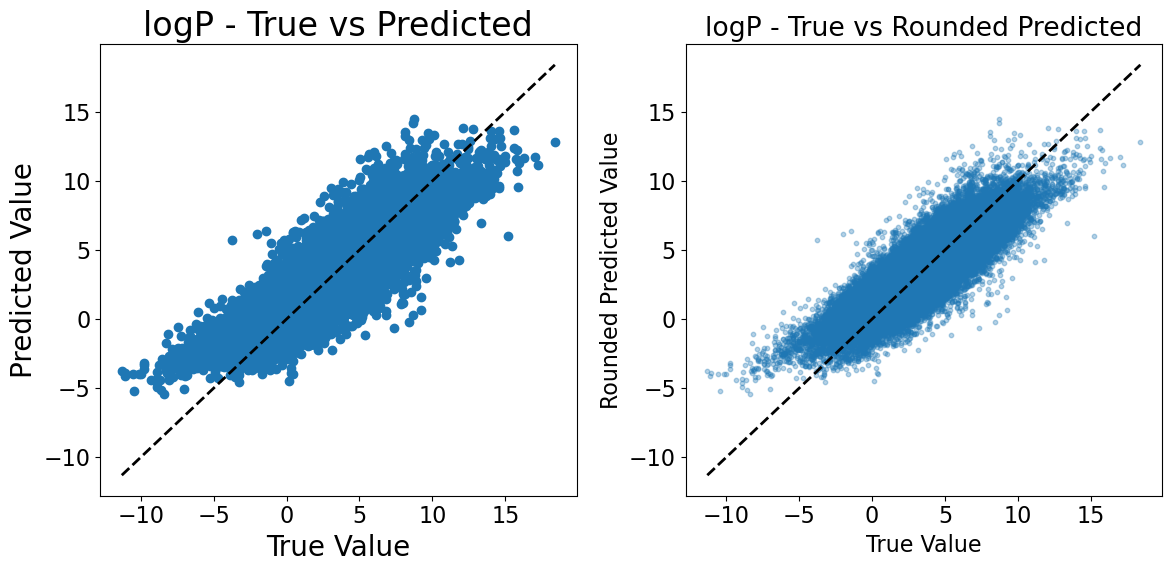

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the properties and their indices
properties = ['HBA', 'HBD', 'MW', 'NumRotBonds', 'QED', 'SAS', 'TPSA', 'logP']
num_properties = len(properties)

# Define the true and predicted values
true_values_np = np.array([value.cpu().numpy() for value in true_values])
predicted_values_np = np.array([value.cpu().numpy() for value in predicted_values])
# Round the predicted values for 'HBA', 'HBD', and 'NumRotBonds'
rounded_predicted_values = np.round(predicted_values_np)
predicted_values_np[:, 0:2] = rounded_predicted_values[:, 0:2]

plt.rcParams.update({'font.size': 16})  # Change 12 to the desired font size
# Create a scatter plot for each property
for i in range(num_properties):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(true_values_np[:, i], predicted_values_np[:, i])
    plt.title(f'{properties[i]} - True vs Predicted', fontsize=24)
    plt.xlabel('True Value', fontsize=20)
    plt.ylabel('Predicted Value', fontsize=20)
    plt.plot([true_values_np[:, i].min(), true_values_np[:, i].max()], 
                [true_values_np[:, i].min(), true_values_np[:, i].max()], 'k--', lw=2)
    plt.subplot(1, 2, 2)
    plt.scatter(true_values_np[:, i], predicted_values_np[:, i], alpha = 0.33, s=10)
    plt.title(f'{properties[i]} - True vs Rounded Predicted')
    plt.xlabel('True Value')
    plt.ylabel('Rounded Predicted Value')
    plt.plot([true_values_np[:, i].min(), true_values_np[:, i].max()], 
                [true_values_np[:, i].min(), true_values_np[:, i].max()], 'k--', lw=2)
    plt.tight_layout()
    plt.savefig(f'/home/10714016/gpt/result/combined_data/encode5_prop_pp/prop_pp_{properties[i]}.jpg')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Define the properties and their indices
properties = ['HBA', 'HBD', 'MW', 'NumRotBonds', 'QED', 'SAS', 'TPSA', 'logP']
num_properties = len(properties)

# Define the true and predicted values
true_values_np = np.array([value.cpu().numpy() for value in true_values])
predicted_values_np = np.array([value.cpu().numpy() for value in predicted_values])
# Round the predicted values for 'HBA', 'HBD', and 'NumRotBonds'
rounded_predicted_values = np.round(predicted_values_np)
predicted_values_np[:, :2] = rounded_predicted_values[:, :2]
predicted_values_np[:, 3:4] = rounded_predicted_values[:, 3:4]

plt.rcParams.update({'font.size': 16})  # Change 12 to the desired font size
# Create a scatter plot for each property
for i in range(num_properties):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(true_values_np[:, i], predicted_values_np[:, i], 
                color = 'royalblue', alpha = 0.3,
                label=f'R2={r2_score(true_values_np[:, i], rounded_predicted_values[:, i]):.2f}')
    plt.title(f'{properties[i]} - True vs Predicted', fontsize=24)
    plt.xlabel('True Value', fontsize=20)
    plt.ylabel('Predicted Value', fontsize=20)
    plt.plot([true_values_np[:, i].min(), true_values_np[:, i].max()], 
             [true_values_np[:, i].min(), true_values_np[:, i].max()], 'k--', lw=2)
    plt.legend()
    #plt.scatter(true_values_np[:, i], predicted_values_np[:, i])
    plt.subplot(1, 2, 2)
    plt.scatter(true_values_np[:, i], predicted_values_np[:, i])
    plt.title(f'{properties[i]} - True vs Rounded Predicted')
    plt.xlabel('True Value')
    plt.ylabel('Rounded Predicted Value')
    plt.plot([true_values_np[:, i].min(), true_values_np[:, i].max()], 
             [true_values_np[:, i].min(), true_values_np[:, i].max()], 'k--', lw=2)
    plt.legend()
    
    plt.tight_layout()
    plt.show()